In [1]:
# Pupil data cleaning based on Knapen et al. by Hamid Turker, Oct 2019


#Here's a quick outline of the workflow:
#1. Generate sample reports in Eyelink Viewer. You can load in EEG_Recollection-SampleReports_Vars_ENCODING.props 
#   into the Viewer to see which variables I drop into the reports. This set of variables is from our recent 
#   EEG+pupillometry study, but they will include everything I also used for tempAttnAudT-ME.

#2. In Matlab, run tempAttnAudT_format_samplereports.m to reformat the sample reports for processing in Python. 
#   I wrote this before I moved most of my processing over to Python, so if you're up for it, you can rewrite this 
#   for Python and possibly save yourself some time.

#3. Download/Install the fir module/package for Python. https://pypi.org/project/fir/

#4. Finally, use this script to perform all typical forms of pupil preprocessing (interpolating across blinks etc) 
#   plus the finite impulse response fitting outlined by Knapen et al. This was originally written to run in Spyder 5 
#   and jupyter notebooks with Python 2. I've adjusted this notebook to run with Python 3 (the main change is the
#   eval of range() vs xrange() used previously). Regardless, things may require some adjustments for a different IDE
#   or different Python version!

#NB: The script can be shortened enormously by removing all the figure plotting it does along the way to visualize 
#    each processing step. But I thought I'd share the longer version so that you get a better idea of what is actually 
#    happening along the way.

# Download the FIRDeconvolution toolbox and, to get you started, set the working directory to be the test folder in the top directory. The top folder will contain such things as their setup.py, the license, and folders such as src and test. The folder src will contain Knapen et al.'s FIRDeconvolution.py and _init_.py.
# We will change our directory to the test folder, which will contain a subfolder called 'data' with example data from the Matlab function that reformatted the sample reports.
# This script, in turn, will generate output files of the preprocessed pupil data that we can then use to run our statistical analyses.

In [2]:
# Dependencies for data preparation and analyses
from __future__ import division
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pl
sn.set(style="ticks")
from fir import FIRDeconvolution
from lmfit import minimize, Parameters, Parameter, report_fit

In [3]:
##########################################################################
                 ##########   LOAD AND LOOK   ########## 
##########################################################################
firdir = '/Users/hamid/Desktop/tknapen-FIRDeconvolution/test/'
os.chdir(firdir)

# Which participant's data?
#for sub in range(15,27):
#    for run in range(1,5):
 
sub = 16
run = 2

# Some data and analysis parameters
sample_rate = 1000                      # Sampling rate of our collected pupil data
trial_deconvolution_interval = 2        # Time window over which we'll perform the deconvolution, fitting, and compute descriptives for further analyses (in seconds)
artifact_deconvolution_interval = 6     # Time window over which we'll perform artifact clean-up (in seconds) [Knapen et al. uses 6 s]
baseline_window = 500                   # Pre-trial time window over which we'll compute the tonic/baseline pupil response

# Load in the data
dict_pupil = pd.read_csv(firdir+'/data/FIR_s'+str(sub)+'_run'+str(run)+'_pupil.csv')     # Pupil diameter data for this run
dict_trial = pd.read_csv(firdir+'/data/FIR_s'+str(sub)+'_run'+str(run)+'_trials.csv')    # Timepoints for trial onsets on this run
dict_blink = pd.read_csv(firdir+'/data/FIR_s'+str(sub)+'_run'+str(run)+'_blinks.csv')    # Timepoints for blinks on this run
dict_saccs = pd.read_csv(firdir+'/data/FIR_s'+str(sub)+'_run'+str(run)+'_saccades.csv')  # Timepoints for saccades on this run
dict_t_zero = dict_trial[dict_trial.iloc[:,1]==0]                                # Timepoints for baseline (no tone) trials on this run
dict_t_one = dict_trial[dict_trial.iloc[:,1]==1]                                 # Timepoints for distractor trials on this run
dict_t_two = dict_trial[dict_trial.iloc[:,1]==2]                                 # Timepoints for target trials on this run
        
# Correct the timestamps so that first timestamp is 0
start_time = dict_pupil.timepoints[0]
timepoints = dict_pupil.timepoints - start_time
        
# Reformat our data so that all timestamps are relative to 0 (= start of eye tracker on this run in the scanner)
pupil = dict_pupil.pupil
blink_starts = np.array(dict_blink.blink_start - start_time, dtype=int)
blink_ends = np.array(dict_blink.blink_end - start_time, dtype=int)
saccs_starts = np.array(dict_saccs.saccs_start - start_time, dtype=int)
saccs_ends = np.array(dict_saccs.saccs_end - start_time, dtype=int)
trial_starts = np.array(dict_trial.trial_start - start_time, dtype=int)
zero_starts = np.array(dict_t_zero.trial_start - start_time, dtype=int)
one_starts = np.array(dict_t_one.trial_start - start_time, dtype=int)
two_starts = np.array(dict_t_two.trial_start - start_time, dtype=int)

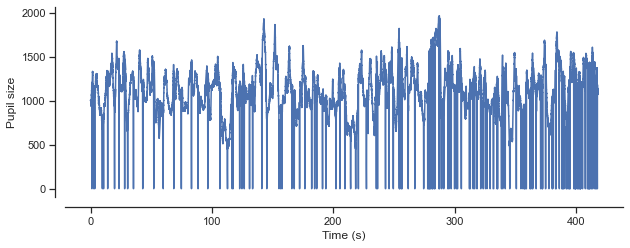

In [4]:
# Plot raw pupil times to ensure data have been loaded in properly.
# You should see a typical jagged time series with lots of timepoints where the value drops to 0.
x = np.arange(timepoints.shape[0]) / sample_rate
f = pl.figure(figsize = (10,3.5))
pl.plot(x, pupil)
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
sn.despine(offset=10)

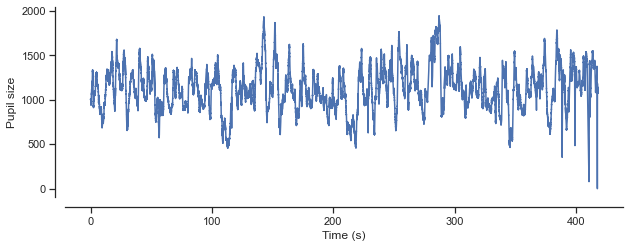

In [5]:
##########################################################################
                ##########   DATA PREP & CHECK   ########## 
##########################################################################
# Linear interpolation of blinks
margin = 100 # ms
margin = int((margin*sample_rate)/1000)
pupil_interpolated = np.array(pupil.copy())

for b in range(blink_starts.shape[0]):
    blink_start =  np.where(timepoints==blink_starts[b])[0][0]-margin+1
    if blink_start < 0: # Add an exception for participants who blinked while the scan started
        blink_start = 0
    if b == blink_starts.shape[0]-1: # Add an exception for participants who blinked while the scan ended
        break
    blink_end =  np.where(timepoints==blink_ends[b])[0][0]+margin+1
    interpolated_signal = np.linspace(pupil_interpolated[blink_start], 
                                              pupil_interpolated[blink_end],
                                              blink_end-blink_start,
                                              endpoint=False)
    pupil_interpolated[blink_start:blink_end] = interpolated_signal
        
# Plot interpolated timeseries
f = pl.figure(figsize = (10,3.5))
pl.plot(x, pupil_interpolated)
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
sn.despine(offset=10)

# We should now see that drops to 0 are gone (though there may still be steep drops in diameter here and there)

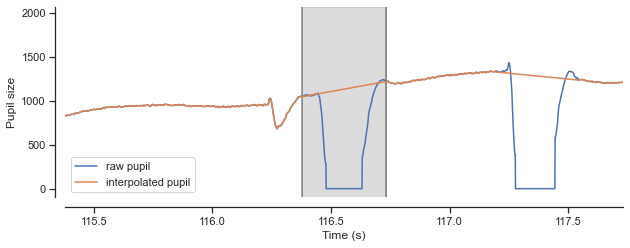

In [6]:
# Zoom in on one blink
blink_i = 21
f = pl.figure(figsize = (10,3.5))
pl.axvspan((-margin + blink_starts[blink_i]) / sample_rate, (margin + blink_ends[blink_i]) / sample_rate, alpha=0.15, color='k')
pl.axvline((-margin + blink_starts[blink_i]) / sample_rate, color = 'k', alpha = 0.5, lw = 1.5)
pl.axvline((margin + blink_ends[blink_i]) / sample_rate, color = 'k', alpha = 0.5, lw = 1.5)
pl.plot(x, pupil, label='raw pupil')
pl.plot(x, pupil_interpolated, label='interpolated pupil')
pl.xlim((-margin + blink_starts[blink_i] - 1000) / sample_rate, (margin + blink_ends[blink_i] + 1000) / sample_rate)
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.legend(loc=3)
sn.despine(offset=10)

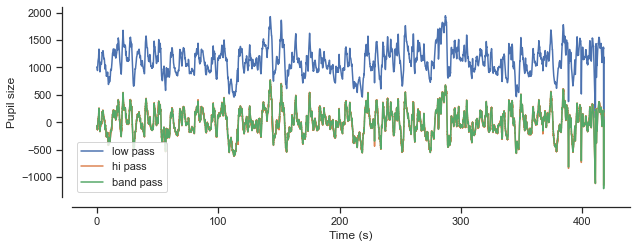

In [7]:
# Filter blink interpolated pupil timeseries now. We'll construct a low pass (<10Hz), and a band-pass (0.01-10Hz) 
# signal. These can be adjusted (the Knapen defaults are .01 and 10), but it will require some thinking..
hp = 0.01
lp = 10

# High pass:
hp_cof_sample = hp /  (sample_rate / 2)
bhp, ahp = sp.signal.butter(3, hp_cof_sample, btype='high')
pupil_interpolated_hp = sp.signal.filtfilt(bhp, ahp, pupil_interpolated)
        
# Low pass:
lp_cof_sample = lp / (sample_rate / 2)
blp, alp = sp.signal.butter(3, lp_cof_sample)
pupil_interpolated_lp = sp.signal.filtfilt(blp, alp, pupil_interpolated)
        
# Band pass:
pupil_interpolated_bp = sp.signal.filtfilt(blp, alp, pupil_interpolated_hp)

# See results
f = pl.figure(figsize = (10,3.5))
pl.plot(x, pupil_interpolated_lp, label='low pass')
pl.plot(x, pupil_interpolated_hp, label='hi pass')
pl.plot(x, pupil_interpolated_bp, label='band pass')
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.legend()
sn.despine(offset=10)

/Users/hamid/opt/anaconda3/envs/Abagen36/lib/python3.6/site-packages/fir/FIRDeconvolution.py:226: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.betas, residuals_sum, rank, s = LA.lstsq(self.design_matrix.T, self.resampled_signal.T)


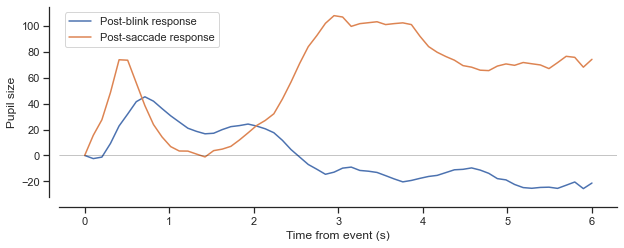

In [12]:
# To account for temporally adjacent events, and hence overlapping responses (due to slow pupil IRF), 
# here we will rely on deconvolution.

# Let's start by finding the typical pupil dilation response to the blinks and saccades
downsample_rate = 100
new_sample_rate = sample_rate / downsample_rate
interval = artifact_deconvolution_interval # How many seconds from end of blink / saccade?
        
# Events:
events = [(blink_ends / sample_rate), 
          (saccs_ends / sample_rate)]
        
# Compute blink and sac kernels with deconvolution (on downsampled timeseries):
a = FIRDeconvolution(signal=sp.signal.decimate(pupil_interpolated_bp, downsample_rate, 1), 
                         events=events, event_names=['blinks', 'saccs'], sample_frequency=new_sample_rate, 
                         deconvolution_frequency=new_sample_rate, deconvolution_interval=[0,interval],)
a.create_design_matrix()
a.regress()
a.betas_for_events()
blink_response = np.array(a.betas_per_event_type[1]).ravel()
sacc_response = np.array(a.betas_per_event_type[0]).ravel()
        
# Baseline the kernels (we're setting the first value to 0, for now, later we'll subtract a pre-stim baseline)
blink_response = blink_response - blink_response[0]
sacc_response = sacc_response - sacc_response[0]
        
# Plot:
x = np.linspace(0, interval, len(blink_response))
f = pl.figure(figsize = (10,3.5))
pl.plot(x, blink_response, label='Post-blink response')
pl.plot(x, sacc_response, label='Post-saccade response')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)
        
# In my experience, post-blinks are best modelled by a double IRF whereas post-saccades are best accounted 
# for with single IRFs. However, as always, inspect, inspect, inspect!

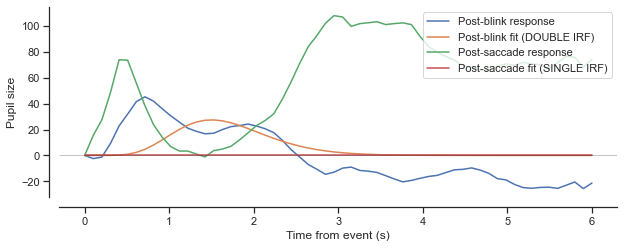

In [13]:
# Fit the kernels
def single_pupil_IRF(params, x):
    s1 = params['s1']
    n1 = params['n1']
    tmax1 = params['tmax1']
    return s1 * ((x**n1) * (np.e**((-n1*x)/tmax1)))

def single_pupil_IRF_ls(params, x, data):
    s1 = params['s1'].value
    n1 = params['n1'].value
    tmax1 = params['tmax1'].value
    model = s1 * ((x**n1) * (np.e**((-n1*x)/tmax1)))
    return model - data

def double_pupil_IRF(params, x):
    s1 = params['s1']
    s2 = params['s2']
    n1 = params['n1']
    n2 = params['n2']
    tmax1 = params['tmax1']
    tmax2 = params['tmax2']
    return s1 * ((x**n1) * (np.e**((-n1*x)/tmax1))) + s2 * ((x**n2) * (np.e**((-n2*x)/tmax2)))

def double_pupil_IRF_ls(params, x, data):
    s1 = params['s1'].value
    s2 = params['s2'].value
    n1 = params['n1'].value
    n2 = params['n2'].value
    tmax1 = params['tmax1'].value
    tmax2 = params['tmax2'].value
    model = s1 * ((x**n1) * (np.e**((-n1*x)/tmax1))) + s2 * ((x**n2) * (np.e**((-n2*x)/tmax2)))
    return model - data

# Create a set of parameters, initialize values, and set reasonable constraints (values directly from Knapen et al.)
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=9, max=11)
params.add('n2', value=10, min=8, max=12)
params.add('tmax1', value=0.9, min=0.5, max=1.5)
params.add('tmax2', value=2.5, min=1.5, max=4)
# Fit the model, here with powell method:
blink_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, blink_response))
blink_kernel = double_pupil_IRF(blink_result.params, x)
sacc_result = minimize(single_pupil_IRF_ls, params, method='powell', args=(x, sacc_response))
sacc_kernel = single_pupil_IRF(sacc_result.params, x)

# If everything has gone well, our kernels should decently fit our blink and saccade data.

# Plot our fitted models:
f = pl.figure(figsize = (10,3.5))
pl.plot(x, blink_response, label='Post-blink response')
pl.plot(x, blink_kernel, label='Post-blink fit (DOUBLE IRF)')
pl.plot(x, sacc_response, label='Post-saccade response')
pl.plot(x, sacc_kernel, label='Post-saccade fit (SINGLE IRF)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=1)
sn.despine(offset=10)

# !!! Inspect visually which set of parameters provide the best fit. Additionally, one can use report_fit for a quantification of fit !!!
#report_fit(blink_result)
#report_fit(sacc_result)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 3399
    # data points      = 60
    # variables        = 6
    chi-square         = 3509.22859
    reduced chi-square = 64.9857146
    Akaike info crit   = 256.128417
    Bayesian info crit = 268.694485
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    s1:    -0.00154772 (init = -1)
    s2:     745.609944 (init = 1)
    n1:     12.0000000 (init = 10)
    n2:     2.85934748 (init = 10)
    tmax1:  6.11076336 (init = 1)
    tmax2:  0.94305125 (init = 1)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 72
    # data points      = 60
    # variables        = 6
    chi-square         = 277533.045
    reduced chi-square = 5139.50083
    Akaike info

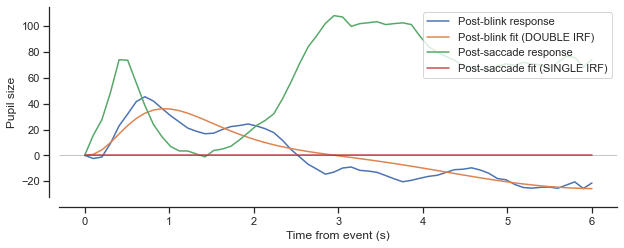

In [10]:
# Or, use more loose parameter boundaries to see if they fit better
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=1e-25, max=12)
params.add('n2', value=10, min=1e-25, max=12)
params.add('tmax1', value=1, min=1e-25, max=10)
params.add('tmax2', value=1, min=1e-25, max=10)
# Fit the model, here with powell method:
blink_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, blink_response))
blink_kernel = double_pupil_IRF(blink_result.params, x)
sacc_result = minimize(single_pupil_IRF_ls, params, method='powell', args=(x, sacc_response))
sacc_kernel = single_pupil_IRF(sacc_result.params, x)

# If everything has gone well, our kernels should decently fit our blink and saccade data.
# Plot our fitted models:
f = pl.figure(figsize = (10,3.5))
pl.plot(x, blink_response, label='Post-blink response')
pl.plot(x, blink_kernel, label='Post-blink fit (DOUBLE IRF)')
pl.plot(x, sacc_response, label='Post-saccade response')
pl.plot(x, sacc_kernel, label='Post-saccade fit (SINGLE IRF)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=1)
sn.despine(offset=10)

# !!! Inspect visually which set of parameters provide the best fit. Additionally, one can use report_fit for a quantification of fit !!!
report_fit(blink_result)
report_fit(sacc_result)

# Generally speaking, the less constrained parameters provide a better fit. But, of course, one shouldn't aim
# to overfit. So, this all requires a bit of thinking and researcher degrees of freedom.

/Users/hamid/opt/anaconda3/envs/Abagen36/lib/python3.6/site-packages/fir/FIRDeconvolution.py:226: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.betas, residuals_sum, rank, s = LA.lstsq(self.design_matrix.T, self.resampled_signal.T)


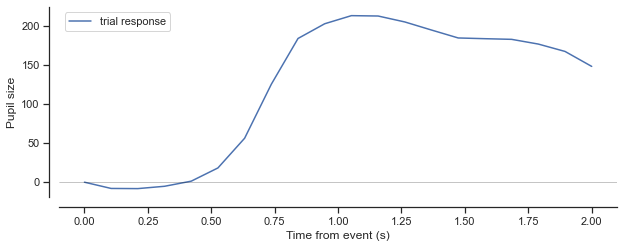

In [14]:
# Next, let's see the typical trial response as well (no distinction based on tone type -- 
# just combine all 144 trials on this run of tempAttnAudTME)
interval = trial_deconvolution_interval # Time window from trial start (2.5 s = 1 TR)

# Events:
events = [(trial_starts / sample_rate)]

# Compute trial kernel with deconvolution (on downsampled timeseries):
a = FIRDeconvolution(signal=sp.signal.decimate(pupil_interpolated_bp, downsample_rate, 1), 
                         events=events, event_names=['trials'], sample_frequency=new_sample_rate, 
                         deconvolution_frequency=new_sample_rate, deconvolution_interval=[0,interval],)
a.create_design_matrix()
a.regress()
a.betas_for_events()
trial_response = np.array(a.betas_per_event_type[0]).ravel()
trial_response = trial_response - trial_response[0]

# We should see a dilation response between .5-1 s after trial onset (a bump), which
# is then followed by a second bump at about 1.25 s after stimulus onset.
# As a reminder, the visual stimulus was on screen for 1.25 s, followed either by a new stimulus or a mask.
# Plot:
x = np.linspace(0, interval, len(trial_response))
f = pl.figure(figsize = (10,3.5))
pl.plot(x, trial_response, label='trial response')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)

1000

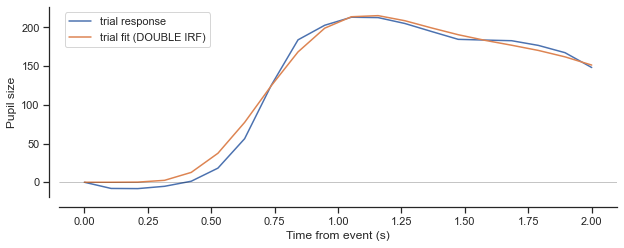

In [15]:
# Fit the kernel for the trials. Based on the previous plot, it's likely we need a double gamma IRF to model this.
# Double IRF parameters and plot (based on Knapen et al., but tmax values adjusted for phasic pupil responses):
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=9, max=11)
params.add('n2', value=10, min=8, max=12)
params.add('tmax1', value=1, min=1e-25, max=10)
params.add('tmax2', value=1, min=1e-25, max=10)

trial_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, trial_response))
trial_kernel = double_pupil_IRF(trial_result.params, x)
f = pl.figure(figsize = (10,3.5))
pl.plot(x, trial_response, label='trial response')
pl.plot(x, trial_kernel, label='trial fit (DOUBLE IRF)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)

# Compute area under the curve (AUC) for double IRF kernel (i.e., the fitted line).
# Compute once with Simpson's rule and once with Trapezoidal rule for comparison. Should be similar.
# Also compare the AUC and the peak of the fit to those of the raw data. Is it sensible? If not, something's gone wrong.


# You can also compare the following measures we'll be taking, between the raw data and the fitted data.
# Fitted
sp.integrate.simps(trial_kernel)            # Simpson's rule
np.trapz(trial_kernel)                      # Trapezoidal rule
trial_kernel[np.argmax(trial_kernel)]       # Peak
np.argmax(trial_kernel)*downsample_rate     # Peak latency (rough estimate)
# Raw data
sp.integrate.simps(trial_response)          # Simpson's rule
np.trapz(trial_response)                    # Trapezoidal rule
trial_response[np.argmax(trial_response)]   # Peak of the raw data
np.argmax(trial_response)*downsample_rate   # Peak latency (rough estimate)

/Users/hamid/opt/anaconda3/envs/Abagen36/lib/python3.6/site-packages/fir/FIRDeconvolution.py:226: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.betas, residuals_sum, rank, s = LA.lstsq(self.design_matrix.T, self.resampled_signal.T)


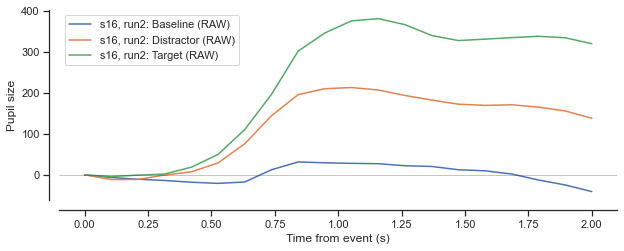

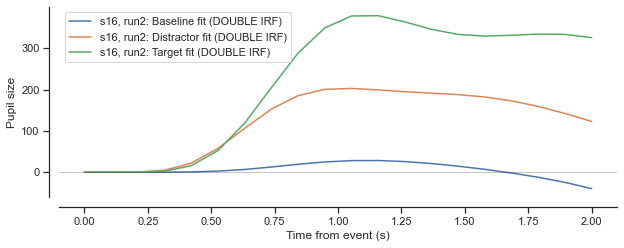

In [17]:
 # Let's repeat this process, but now we split the trials up by tonetype (i.e. baseline, distractor, target trials)
interval = trial_deconvolution_interval # Time window from trial start

# Events:
events = [(zero_starts / sample_rate),
          (one_starts / sample_rate),
          (two_starts / sample_rate)]

# Compute blink and saccade kernels with deconvolution (on downsampled timeseries):
a = FIRDeconvolution(signal=sp.signal.decimate(pupil_interpolated_bp, downsample_rate, 1), 
                         events=events, event_names=['zero', 'one', 'two'], sample_frequency=new_sample_rate, 
                         deconvolution_frequency=new_sample_rate, deconvolution_interval=[0,interval],)

a.create_design_matrix()
a.regress()
a.betas_for_events()
zero_response = np.array(a.betas_per_event_type[0]).ravel()
one_response = np.array(a.betas_per_event_type[1]).ravel()
two_response = np.array(a.betas_per_event_type[2]).ravel()
zero_response = zero_response - zero_response[0]
one_response = one_response - one_response[0]
two_response = two_response - two_response[0]

# Plot raw data for each tone condition in this run:
x = np.linspace(0, interval, len(zero_response))
f = pl.figure(figsize = (10,3.5))
pl.plot(x, zero_response, label='s'+str(sub)+', run'+str(run)+': Baseline (RAW)')
pl.plot(x, one_response, label='s'+str(sub)+', run'+str(run)+': Distractor (RAW)')
pl.plot(x, two_response, label='s'+str(sub)+', run'+str(run)+': Target (RAW)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)

# Now, let's fit the data per tone condition
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=9, max=11)
params.add('n2', value=10, min=8, max=12)
params.add('tmax1', value=1, min=1e-25, max=10)
params.add('tmax2', value=1, min=1e-25, max=10)

baseline_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, zero_response))
baseline_kernel = double_pupil_IRF(baseline_result.params, x)
distractor_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, one_response))
distractor_kernel = double_pupil_IRF(distractor_result.params, x)
target_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, two_response))
target_kernel = double_pupil_IRF(target_result.params, x)

# Plot the fits for each condition
f = pl.figure(figsize = (10,3.5))
pl.plot(x, baseline_kernel, label='s'+str(sub)+', run'+str(run)+': Baseline fit (DOUBLE IRF)')
pl.plot(x, distractor_kernel, label='s'+str(sub)+', run'+str(run)+': Distractor fit (DOUBLE IRF)')
pl.plot(x, target_kernel, label='s'+str(sub)+', run'+str(run)+': Target fit (DOUBLE IRF)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)

# Baseline AUC & Peak
#sp.integrate.simps(baseline_kernel)                     # Simpson's rule
#np.trapz(baseline_kernel)                               # Trapezoidal rule
#baseline_kernel[np.argmax(baseline_kernel)]             # Fit Max (Peak)
#np.argmax(baseline_kernel)*downsample_rate              # Fit Max latency (ms)
#baseline_kernel[np.argmin(baseline_kernel)]             # Fit Min (Trough)
#np.argmin(baseline_kernel)*downsample_rate              # Fit Min latency (ms)

# Distractor AUC & Peak
#sp.integrate.simps(distractor_kernel)                   # Simpson's rule
#np.trapz(distractor_kernel)                             # Trapezoidal rule
#distractor_kernel[np.argmax(distractor_kernel)]         # Fit Max (Peak)
#np.argmax(distractor_kernel)*downsample_rate            # Fit Max latency (ms)
#distractor_kernel[np.argmin(distractor_kernel)]         # Fit Min (Trough)
#np.argmin(distractor_kernel)*downsample_rate            # Fit Min latency (ms)

# Target AUC & Peak
#sp.integrate.simps(target_kernel)                       # Simpson's rule
#np.trapz(target_kernel)                                 # Trapezoidal rule
#target_kernel[np.argmax(target_kernel)]                 # Fit Max (Peak)
#np.argmax(target_kernel)*downsample_rate                # Fit Max latency (ms)
#target_kernel[np.argmin(target_kernel)]                 # Fit Min (Trough)
#np.argmin(target_kernel)*downsample_rate                # Fit Min latency (ms)

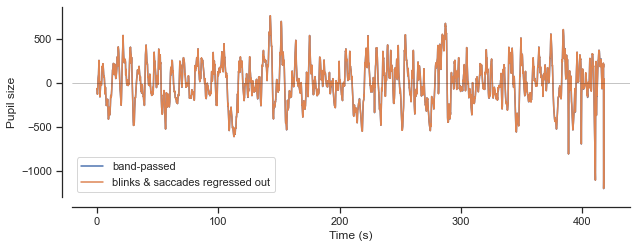

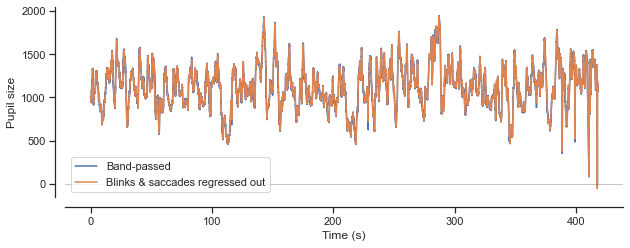

In [18]:
##########################################################################
             ##########   DATA CLEANING   ########## 
##########################################################################
# Knapen et al. suggest that blinks and saccades can contribute to pupil diameter in a way not accounted for by 
# interpolation. Therefore, with a GLM, let's regress out pupil dilation measurement errors due to blinks and 
# saccades.

# Upsample:
x = np.linspace(0, interval, interval*sample_rate)
blink_kernel = double_pupil_IRF(blink_result.params, x)
sacc_kernel = double_pupil_IRF(sacc_result.params, x)

# Regressors:
blink_reg = np.zeros(len(pupil))
blink_reg[blink_ends] = 1
blink_reg_conv = sp.signal.fftconvolve(blink_reg, blink_kernel, 'full')[:-(len(blink_kernel)-1)]
sacc_reg = np.zeros(len(pupil))
sacc_reg[blink_ends] = 1
sacc_reg_conv = sp.signal.fftconvolve(sacc_reg, sacc_kernel, 'full')[:-(len(sacc_kernel)-1)]
regs = [blink_reg_conv, sacc_reg_conv]

# GLM:
design_matrix = np.matrix(np.vstack([reg for reg in regs])).T
betas = np.array(((design_matrix.T * design_matrix).I * design_matrix.T) * np.matrix(pupil_interpolated_bp).T).ravel()
explained = np.sum(np.vstack([betas[i]*regs[i] for i in range(len(betas))]), axis=0)

# Clean pupil:
pupil_clean_bp = pupil_interpolated_bp - explained

# Plot clean pupil data:
x = np.arange(timepoints.shape[0]) / sample_rate
f = pl.figure(figsize = (10,3.5))
pl.plot(x, pupil_interpolated_bp, label='band-passed')
pl.plot(x, pupil_clean_bp, label='blinks & saccades regressed out')
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend()
sn.despine(offset=10)

##########################################################################
# Next, we'll add back the slow drift, which is a meaningful part of the signal!
pupil_clean = pupil_clean_bp + (pupil_interpolated_lp-pupil_interpolated_bp)
f = pl.figure(figsize = (10,3.5))
x = np.arange(timepoints.shape[0]) / sample_rate
pl.plot(x, pupil_interpolated, label='Band-passed')
pl.plot(x, pupil_clean, label='Blinks & saccades regressed out')
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=3)
sn.despine(offset=10)

/Users/hamid/opt/anaconda3/envs/Abagen36/lib/python3.6/site-packages/fir/FIRDeconvolution.py:226: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.betas, residuals_sum, rank, s = LA.lstsq(self.design_matrix.T, self.resampled_signal.T)
/Users/hamid/opt/anaconda3/envs/Abagen36/lib/python3.6/site-packages/fir/FIRDeconvolution.py:226: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.betas, residuals_sum, rank, s = LA.lstsq(self.design_matrix.T, self.resampled_signal.T)


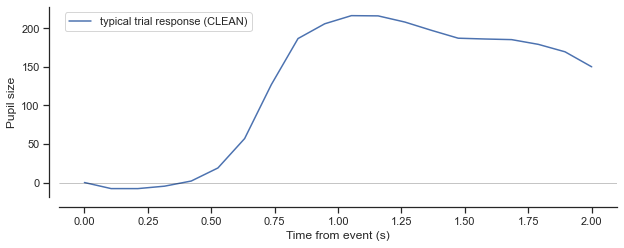

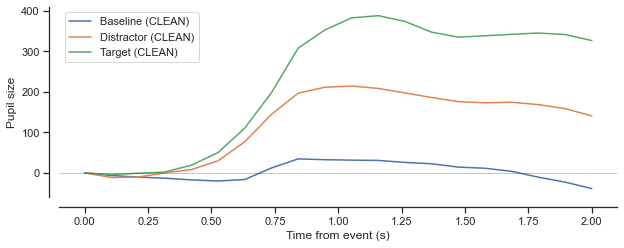

In [20]:
##########################################################################
  ##########   VISUALLY INSPECT DOWNSAMPLED CLEAN DATA   ########## 
##########################################################################
# Typical trial on clean data
interval = trial_deconvolution_interval # Time window from trial start
events = [(trial_starts / sample_rate)]
a = FIRDeconvolution(signal=sp.signal.decimate(pupil_clean, downsample_rate, 1), 
                         events=events, event_names=['trials'], sample_frequency=new_sample_rate, 
                         deconvolution_frequency=new_sample_rate, deconvolution_interval=[0,interval],)

a.create_design_matrix()
a.regress()
a.betas_for_events()
trial_response_clean = np.array(a.betas_per_event_type[0]).ravel()
trial_response_clean = trial_response_clean - trial_response_clean[0].mean()

# Plot:
x = np.linspace(0, interval, len(trial_response_clean))
f = pl.figure(figsize = (10,3.5))
pl.plot(x, trial_response_clean, label='typical trial response (CLEAN)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)

##########################################################################
# Clean data by trial condition
interval = trial_deconvolution_interval # Time window from trial start
events = [(zero_starts / sample_rate),
          (one_starts / sample_rate),
          (two_starts / sample_rate)]

a = FIRDeconvolution(signal=sp.signal.decimate(pupil_clean, downsample_rate, 1), 
                         events=events, event_names=['zero', 'one', 'two'], sample_frequency=new_sample_rate, 
                         deconvolution_frequency=new_sample_rate, deconvolution_interval=[0,interval],)

a.create_design_matrix()
a.regress()
a.betas_for_events()
zero_response_clean = np.array(a.betas_per_event_type[0]).ravel()
one_response_clean = np.array(a.betas_per_event_type[1]).ravel()
two_response_clean = np.array(a.betas_per_event_type[2]).ravel()

zero_response_clean = zero_response_clean - zero_response_clean[0]
one_response_clean = one_response_clean - one_response_clean[0]
two_response_clean = two_response_clean - two_response_clean[0]

# Plot:
x = np.linspace(0, interval, len(zero_response_clean))
f = pl.figure(figsize = (10,3.5))
pl.plot(x, zero_response_clean, label='Baseline (CLEAN)')
pl.plot(x, one_response_clean, label='Distractor (CLEAN)')
pl.plot(x, two_response_clean, label='Target (CLEAN)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)

# Baseline AUC & Peak
#sp.integrate.simps(zero_response_clean)                 # Simpson's rule
#np.trapz(zero_response_clean)                           # Trapezoidal rule
#zero_response_clean[np.argmax(zero_response_clean)]     # Clean Pupil Max (Peak)
#np.argmax(zero_response_clean)*downsample_rate          # Clean Pupil Max latency (ms) rough estimate
#zero_response_clean[np.argmin(zero_response_clean)]     # Clean Pupil Min (Trough)
#np.argmin(zero_response_clean)*downsample_rate          # Clean Pupil Min latency (ms) rough estimate

# Distractor AUC & Peak
#sp.integrate.simps(one_response_clean)                  # Simpson's rule
#np.trapz(one_response_clean)                            # Trapezoidal rule
#one_response_clean[np.argmax(one_response_clean)]       # Clean Pupil Max (Peak)
#np.argmax(one_response_clean)*downsample_rate           # Clean Pupil Max latency (ms) rough estimate
#one_response_clean[np.argmin(one_response_clean)]       # Clean Pupil Min (Trough)
#np.argmin(one_response_clean)*downsample_rate           # Clean Pupil Min latency (ms) rough estimate

# Target AUC & Peak
#sp.integrate.simps(two_response_clean)                  # Simpson's rule
#np.trapz(two_response_clean)                            # Trapezoidal rule
#two_response_clean[np.argmax(two_response_clean)]       # Clean Pupil Max (Peak)
#np.argmax(two_response_clean)*downsample_rate           # Clean Pupil Max latency (ms) rough estimate
#two_response_clean[np.argmin(two_response_clean)]       # Clean Pupil Min (Trough)
#np.argmin(two_response_clean)*downsample_rate           # Clean Pupil Min latency (ms) rough estimate

In [28]:
##########################################################################
    ##########   PRINT TRIAL MEASURES ON CLEAN & RAW DATA   ########## 
##########################################################################
# We'll create a file with the entire cleaned up timeseries
subrun = []
for i in range(0,len(timepoints)):
    subrun.append([sub, run])
all_timeseries = pd.DataFrame(subrun, columns=['Subid', 'Run'])
all_timeseries['Timepoints'] = timepoints
all_timeseries['Raw'] = pupil_interpolated
all_timeseries['Clean'] = pupil_clean
timeseries_filename = 'Timeseries_s'+str(sub)+'_run'+str(run)+'_artwin'+str(artifact_deconvolution_interval)+'_triwin'+str(trial_deconvolution_interval)+'.csv'
all_timeseries.to_csv(timeseries_filename, header=True, index=False, index_label=False)

# And we'll create a file with info on the trials
subrun = []
for i in range(0,len(trial_starts)):
    subrun.append([sub, run])
trialtimes = pd.DataFrame(subrun, columns=['Subid', 'Run'])
trialtimes['TrialTimes'] = trial_starts
trialtimes['TrialCondition'] = dict_trial.iloc[:,1]
trialtimes_filename = 'Trials_s'+str(sub)+'_run'+str(run)+'_artwin'+str(artifact_deconvolution_interval)+'_triwin'+str(trial_deconvolution_interval)+'.csv'
trialtimes.to_csv(trialtimes_filename, header=True, index=False, index_label=False)

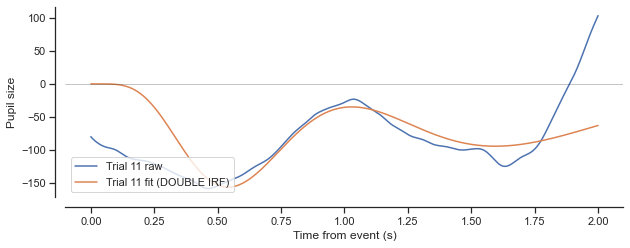

In [42]:
# Okay, we're ready to get going. This code block is to try out different parameters one last time, to take
# note of the actual baseline procedure, and to inspect specific trials. The next code block after this runs the
# actual fitting on the real data to generate outcome measures of interest.

# Parameters for fitting
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=1e-25, max=12)
params.add('n2', value=10, min=1e-25, max=12)
params.add('tmax1', value=1, min=1e-25, max=10)
params.add('tmax2', value=1, min=1e-25, max=10)

# Set the size of the trial window
trial_window = int(trial_deconvolution_interval*sample_rate)

# Also note that we're now using a pre-stimulus baseline defined earlier (trial_baseline below)

t = 10 # Pick a trial, any trial!

# Compute measures of interest
outcomes = []
trial_end = trial_starts[t]+trial_window                                                                    # Compute this trial's ending
this_trial = pupil_clean[trial_starts[t]:trial_end]                                                         # Slice out that part of the clean pupil's timeseries corresponding to the current trial
x = np.linspace(0, interval, len(this_trial))                                                               # Ensure that the shape of our x-axis matches shape of this trial
trial_baseline = pupil_clean[trial_starts[t]-baseline_window:trial_starts[t]]                               # Compute this trial's tonic/baseline window
trial_baseline = np.mean(trial_baseline)                                                                    # Baseline the tonic/baseline measure and compute mean
this_trial = this_trial - trial_baseline                                                                    # Baseline correct the trial
this_trial_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, this_trial))            # Fit the double gamma IRF to this trial over the x-axis
this_trial_kernel = double_pupil_IRF(this_trial_result.params, x)
trial_auc_s = sp.integrate.simps(this_trial_kernel)                                                         # Compute this trial's AUC with Simpson's rule
trial_auc_t = np.trapz(this_trial_kernel)                                                                   # And now with the Trapezoidal rule
max_fit = this_trial_kernel[np.argmax(this_trial_kernel)]                                                   # Compute the peak of the kernel
max_lat = np.argmax(this_trial_kernel)*(downsample_rate/10)                                                 # Compute latency of peak of the kernel
min_fit = this_trial_kernel[np.argmin(this_trial_kernel)]                                                   # Compute trough of the kernel
min_lat = np.argmin(this_trial_kernel)*(downsample_rate/10)                                                 # Compute latency of trough of the kernel
condition = dict_trial.iloc[t,1]                                                                            # Tone condition for this trial
outcomes.append([sub, run, t+1, trial_starts[t]/sample_rate, trial_end/sample_rate, trial_auc_s, trial_auc_t, max_fit, max_lat, min_fit, min_lat, trial_baseline])  # Hold on to our descriptives for this trial

# Plot
f = pl.figure(figsize = (10,3.5))                                                                           
pl.plot(x, this_trial, label='Trial '+str(t+1)+' raw')
pl.plot(x, this_trial_kernel, label='Trial '+str(t+1)+' fit (DOUBLE IRF)')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=3)
sn.despine(offset=10)

# How does it look? Is it a reasonable fit? Look at the 'outcomes' dataframe. Do you get what's going on?

In [43]:
##########################################################################
     ##########   GET TRIAL DESCRIPTIVES ON CLEAN DATA   ########## 
##########################################################################
# OKAY, THIS IS IT! This is for realsies now! No cap. Whatever parameter values
# you set here are the ones that your eventual measures will be created with.

# Parameters
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=1e-25, max=12)
params.add('n2', value=10, min=1e-25, max=12)
params.add('tmax1', value=1, min=1e-25, max=10)
params.add('tmax2', value=1, min=1e-25, max=10)

# Just setting the trial window size
trial_window = int(trial_deconvolution_interval*sample_rate)

# Loop through all the trials and create a data frame that holds all our measures of interest
hold_on = []
for t in range(trial_starts.shape[0]):                                                                         # For every trial..
    trial_end = trial_starts[t]+trial_window                                                                    # Compute this trial's ending
    this_trial = pupil_clean[trial_starts[t]:trial_end]                                                         # Slice out that part of the clean pupil's timeseries corresponding to the current trial
    x = np.linspace(0, interval, len(this_trial))                                                               # Ensure that the shape of our x-axis matches shape of this trial
    trial_baseline = pupil_clean[trial_starts[t]-baseline_window:trial_starts[t]]                               # Compute this trial's tonic/baseline window
    trial_baseline = np.mean(trial_baseline)                                                                    # Baseline the tonic/baseline measure and compute mean
    this_trial = this_trial - trial_baseline                                                                    # Baseline correct the trial
    this_trial_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, this_trial))            # Fit the double gamma IRF to this trial over the x-axis
    this_trial_kernel = double_pupil_IRF(this_trial_result.params, x)
    trial_auc_s = sp.integrate.simps(this_trial_kernel)                                                         # Compute this trial's AUC with Simpson's rule
    trial_auc_t = np.trapz(this_trial_kernel)                                                                   # And now with the Trapezoidal rule
    max_fit = this_trial_kernel[np.argmax(this_trial_kernel)]                                                   # Compute the peak of the kernel
    max_lat = np.argmax(this_trial_kernel)*(downsample_rate/10)                                                 # Compute latency of peak of the kernel
    min_fit = this_trial_kernel[np.argmin(this_trial_kernel)]                                                   # Compute trough of the kernel
    min_lat = np.argmin(this_trial_kernel)*(downsample_rate/10)                                                 # Compute latency of trough of the kernel
    condition = dict_trial.iloc[t,1]                                                                            # Tone condition for this trial
    hold_on.append([sub, run, t+1, trial_starts[t]/sample_rate, trial_end/sample_rate, trial_auc_s, trial_auc_t, max_fit, max_lat, min_fit, min_lat, trial_baseline])  # Hold on to our descriptives for this trial
    #f = pl.figure(figsize = (10,3.5))                                                                          # Uncomment to plot raw+fit for the trial
    #pl.plot(x, this_trial, label='Trial '+str(t+1)+' raw')
    #pl.plot(x, this_trial_kernel, label='Trial '+str(t+1)+' fit (DOUBLE IRF)')
    #pl.xlabel('Time from event (s)')
    #pl.ylabel('Pupil size')
    #pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
    #pl.legend(loc=3)
    #sn.despine(offset=10)

In [46]:
# Create the final output file containing the measures of interest
pupil_descriptives = pd.DataFrame(hold_on, columns=['Subid', 'Run', 'Trial', 'StartTime', 'EndTime', 'SimpsonAUC', 'TrapzAUC', 'Maximum', 'MaxLatency', 'Minimum', 'MinLatency', 'Baseline']) # Create a dataframe for the descriptives of all our trials on this run
pupil_descriptives['ToneType'] = dict_trial.iloc[:,1] # Add the trial conditions (0/1/2, Baseline/Distractor/Target) to the dataframe
pupil_descriptives[['Maximum', 'Baseline']].corr(method='pearson')     # Correlation between the (pre-trial) tonic and (trial) phasic peak

,Maximum,Baseline
Maximum,1.000000,-0.480568
Baseline,-0.480568,1.000000


In [45]:
##########################################################################
     ##########   PRINT DESCRIPTIVES TO TEXT   ########## 
##########################################################################
# Finally, we print our data to a .csv file for further processing
file_name = 'FIR_output_s'+str(sub)+'_run'+str(run)+'_artwin'+str(artifact_deconvolution_interval)+'_triwin'+str(trial_deconvolution_interval)+'.csv'
pupil_descriptives.to_csv(file_name, header=True, index=False, index_label=False)



############################################
     ##########   FINISHED!  ########## 
############################################